### langdetect from google

```bash
pip install langdetect
```

In [9]:
from langdetect import detect_langs

text1 = "Dies ist ein deutscher Satz."
text2 = "Ceci est une phrase en français"

langs1 = detect_langs(text1)
langs2 = detect_langs(text2)

print("Text:", text1, "; Result:", langs1[0].lang, "; Confidence:", langs1[0].prob)
print("Text:", text2, "; Result:", langs2[0].lang, "; Confidence:", langs2[0].prob)


Text: Dies ist ein deutscher Satz. ; Result: de ; Confidence: 0.9999991848029228
Text: Ceci est une phrase en français ; Result: fr ; Confidence: 0.9999967227780593


### langid 

```bash
pip install langid
```

In [8]:
import langid

text1 = "Dies ist ein deutscher Satz."
language1, confidence1 = langid.classify(text1)
text2 = "Ceci est une phrase en français"
language2, confidence2 = langid.classify(text2)
print("Text: " + text1 + "; Result: " + language1 + " ; Confidence: " + str(confidence1) )  # Output: 'de'
print("Text: " + text2 + "; Result: " + language2 + " ; Confidence: " + str(confidence2) )  # Output: 'fr'


Text: Dies ist ein deutscher Satz.; Result: de ; Confidence: -127.36260652542114
Text: Ceci est une phrase en français; Result: fr ; Confidence: -151.471538066864


In [ ]:
    "",
    "",
    "",
    ""

In [1]:
from langdetect import detect_langs
import langid
import math

texts = [

    "Lingias da construcziun da las vias naziunalas V2.0 RDPP"

    # "Agenda der Bibliothèque de Genève",
    # "Agenda of the Bibliothèque de Genève",
    # "Agenda de la Bibliothèque de Genève",
    # "Agenda della Bibliothèque de Genève"


    # "5G - NR Verfügbarkeit",
    # "5G - NR availability",
    # "Disponibilité 5G - NR",
    # "Disponibilità 5G - NR"




    # "4G Mobilfunknetze (LTE) - Antennenstandorte",
    # "4G mobile telecom networks (LTE) – antenna locations",
    # "Téléphonie mobile 4G (LTE) - Emplacement des antennes",
    # "Telefonia mobile 4G (LTE) – ubicazione antenne"


    # "2D und 3D Reflexionsseismik in der Schweiz",
    # "2D and 3D reflection seismic in Switzerland",
    # "2D et 3D sismique réflexion en Suisse",
    # "2D e 3D sismica a riflessione in Svizzera"
]

for i, text in enumerate(texts, start=1):
    # langdetect
    ld_result = detect_langs(text)
    ld_lang = ld_result[0].lang
    ld_conf = ld_result[0].prob

    # langid
    li_lang, li_logprob = langid.classify(text)
    li_conf = round(math.exp(li_logprob), 6)  # Convert log-prob to pseudo-probability

    print(f"\nText {i}: {text}")
    print(f"  langdetect: {ld_lang} (confidence: {round(ld_conf, 4)})")
    print(f"  langid    : {li_lang} (log-prob: {round(li_logprob, 2)}; approx. prob: {li_conf})")



Text 1: Lingias da construcziun da las vias naziunalas V2.0 RDPP
  langdetect: es (confidence: 0.5714)
  langid    : eo (log-prob: -191.45; approx. prob: 0.0)


In [6]:
# geoharvester

from langdetect import detect  
def detect_language(phrase, not_found=False):
    """
    Detects the language of a str using langdetect.

    Parameters
    ----------
    phrase : str
        String element to be elaborated
    Returns
    -------
    _ : str
        Detected language.
    """
    if not_found:
        exception = 'not_found'
    else:
        exception = 'english'
    language_dict = {'en': 'english', 'fr': 'french', 'de': 'german', 'it': 'italian'}
    try:
        lang = language_dict[detect(phrase)]
    except:
        lang = exception
    return lang


detect_language("Das ist ein Test")

'german'

In [1]:
import chardet
import pandas as pd

# === Configuration ===
input_file = r"C:\Users\fabia\OneDrive - FHNW\03_FHNW\06_6_Semester\03_6000_BTh\91_NLP Unterlagen\language_detection\languages4.csv"
output_file = input_file.replace(".csv", "_utf8.csv")

# === Step 1: Detect Encoding ===
with open(input_file, "rb") as f:
    result = chardet.detect(f.read(100000))  # scan first 100KB
    detected_encoding = result['encoding']
    print(f"Detected encoding: {detected_encoding}")

# === Step 2: Try reading with detected encoding, fallback to others ===
encodings_to_try = [detected_encoding, 'cp1252', 'latin1', 'utf-8', 'utf-16']

df = None
for enc in encodings_to_try:
    try:
        df = pd.read_csv(input_file, encoding=enc)
        print(f"✅ Successfully read the file with encoding: {enc}")
        break
    except Exception as e:
        print(f"❌ Failed with encoding {enc}: {e}")

# === Step 3: Save as UTF-8 ===
if df is not None:
    try:
        df.to_csv(output_file, index=False, encoding="utf-8", header=True)  # explicit header
        print(f"✅ File converted and saved to:\n{output_file}")
    except Exception as e:
        print(f"❌ Failed to save file as UTF-8. Error: {e}")
else:
    print("❌ Could not read the file with any encoding. No output generated.")


Detected encoding: Windows-1252
✅ Successfully read the file with encoding: Windows-1252
✅ File converted and saved to:
C:\Users\fabia\OneDrive - FHNW\03_FHNW\06_6_Semester\03_6000_BTh\91_NLP Unterlagen\language_detection\languages4_utf8.csv


### Check languages from the title

✅ Full check done — saved to:
C:\Users\fabia\OneDrive - FHNW\03_FHNW\06_6_Semester\03_6000_BTh\91_NLP Unterlagen\language_detection\languages4_check_full.csv


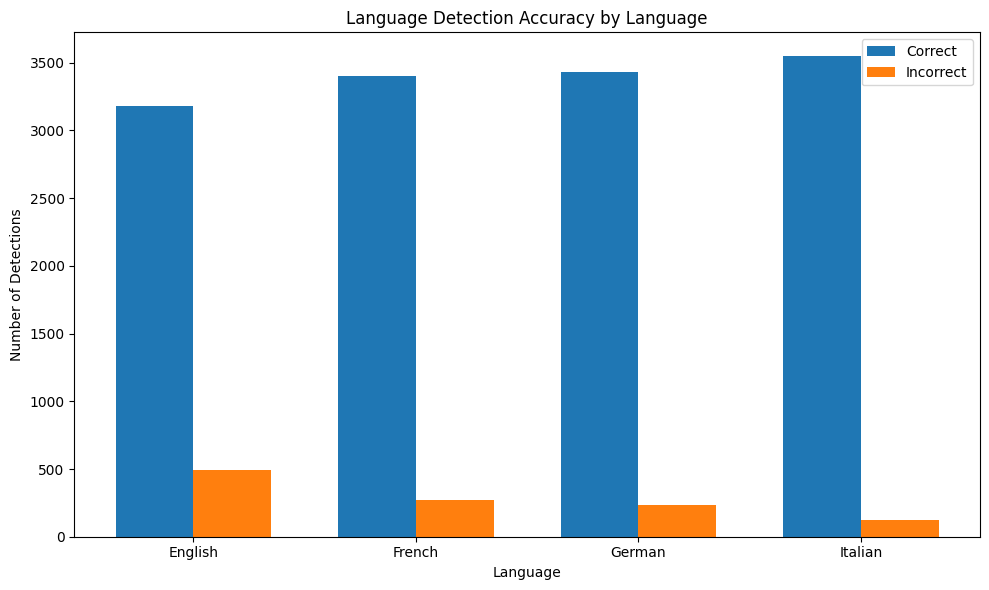

                    Column Language  Correct  Incorrect  Percent Correct  \
0         dataset_title_DE   German     1132         92            92.48   
1         dataset_title_FR   French     1093        131            89.30   
2         dataset_title_IT  Italian     1145         79            93.55   
3         dataset_title_EN  English     1072        152            87.58   
4   dataset_description_DE   German     1223          1            99.92   
5   dataset_description_FR   French     1211         13            98.94   
6   dataset_description_IT  Italian     1207         17            98.61   
7   dataset_description_EN  English     1210         14            98.86   
8       dataset_keyword_DE   German     1080        144            88.24   
9       dataset_keyword_FR   French     1099        125            89.79   
10      dataset_keyword_IT  Italian     1195         29            97.63   
11      dataset_keyword_EN  English      896        328            73.20   

    Percent

In [4]:
import pandas as pd
from langdetect import detect
import re
import matplotlib.pyplot as plt

# Load UTF-8 CSV
df = pd.read_csv(r"C:\Users\fabia\OneDrive - FHNW\03_FHNW\06_6_Semester\03_6000_BTh\91_NLP Unterlagen\language_detection\languages4_utf8.csv", encoding="utf-8")

# Clean function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.replace('\xa0', ' ')  # non-breaking space
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # remove non-ASCII chars (optional)
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)  # remove zero-width characters
    return text.strip()

# Language detection function
def detect_language(phrase, not_found=False):
    if not_found:
        exception = 'not_found'
    else:
        exception = 'english'
    language_dict = {'en': 'english', 'fr': 'french', 'de': 'german', 'it': 'italian'}
    try:
        lang = language_dict[detect(phrase)]
    except:
        lang = exception
    return lang

# Define columns to check
base_columns = ['dataset_title', 'dataset_description', 'dataset_keyword']
languages = {'DE': 'german', 'FR': 'french', 'IT': 'italian', 'EN': 'english'}

# Generate full mapping
column_lang_mapping = {
    f"{base}_{lang}": expected_lang
    for base in base_columns
    for lang, expected_lang in languages.items()
    if f"{base}_{lang}" in df.columns
}

# Clean, detect, and verify
for col, expected_lang in column_lang_mapping.items():
    df[f'{col}_clean'] = df[col].apply(clean_text)
    df[f'{col}_detected_lang'] = df[f'{col}_clean'].apply(lambda x: detect_language(x, not_found=True))
    df[f'{col}_is_correct'] = df[f'{col}_detected_lang'] == expected_lang

# Save updated CSV
output_path_checked = r"C:\Users\fabia\OneDrive - FHNW\03_FHNW\06_6_Semester\03_6000_BTh\91_NLP Unterlagen\language_detection\languages4_check_full.csv"
df.to_csv(output_path_checked, index=False, encoding='utf-8')
print(f"✅ Full check done — saved to:\n{output_path_checked}")

# Summarize results
summary = []
for col, expected_lang in column_lang_mapping.items():
    is_correct_col = f'{col}_is_correct'
    if is_correct_col in df.columns:
        correct = df[is_correct_col].sum()
        total = df[is_correct_col].count()
        incorrect = total - correct
        percent_correct = round((correct / total) * 100, 2)
        percent_incorrect = round((incorrect / total) * 100, 2)

        summary.append({
            'Column': col,
            'Language': expected_lang.capitalize(),
            'Correct': correct,
            'Incorrect': incorrect,
            'Percent Correct': percent_correct,
            'Percent Incorrect': percent_incorrect
        })

# Create DataFrame for summary
summary_df = pd.DataFrame(summary)

# Plot results per language (aggregated)
agg = summary_df.groupby("Language")[["Correct", "Incorrect"]].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
x = range(len(agg))

ax.bar(x, agg['Correct'], width, label='Correct')
ax.bar([i + width for i in x], agg['Incorrect'], width, label='Incorrect')

ax.set_xlabel('Language')
ax.set_ylabel('Number of Detections')
ax.set_title('Language Detection Accuracy by Language')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(agg['Language'])
ax.legend()
plt.tight_layout()
plt.show()

# Optional: Print summary
print(summary_df)


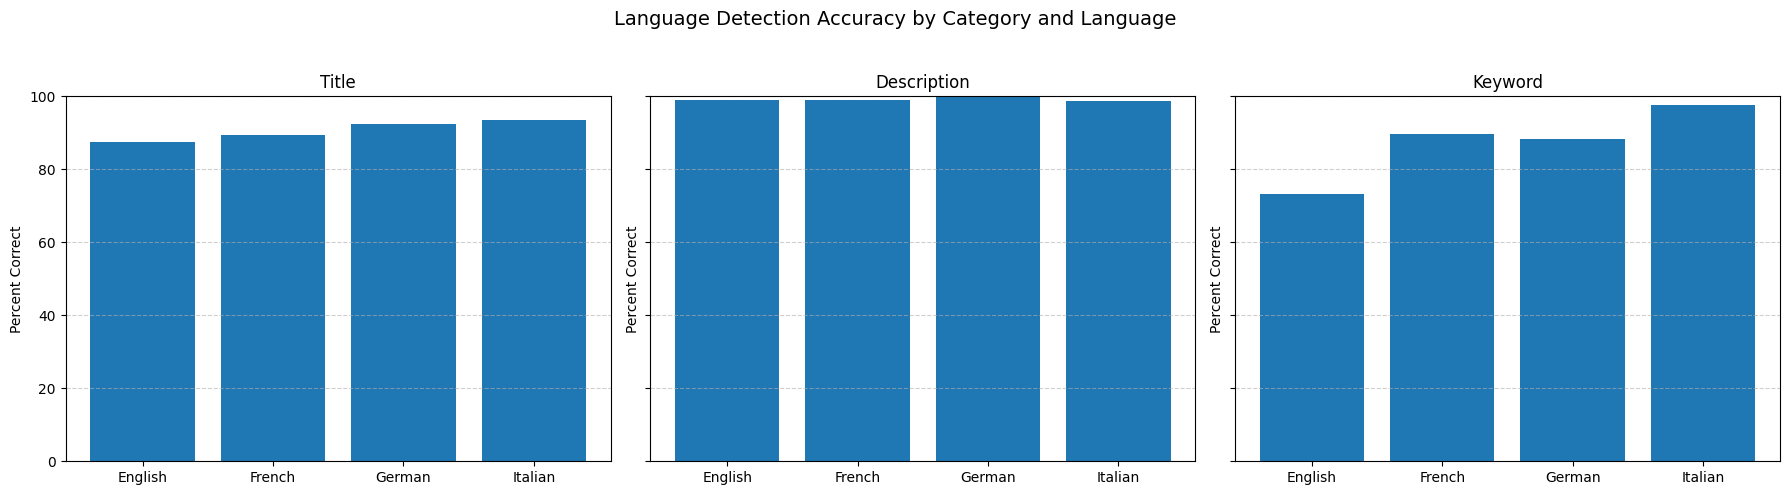

In [9]:
import seaborn as sns

# Small multiples (side-by-side bar charts)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
categories = ['Title', 'Description', 'Keyword']

for ax, category in zip(axes, categories):
    cat_df = summary_df[summary_df['Category'] == category].sort_values('Language')
    ax.bar(cat_df['Language'], cat_df['Percent Correct'])
    ax.set_title(f'{category}')
    ax.set_ylim(0, 100)
    ax.set_ylabel('Percent Correct')
    ax.grid(axis='y', linestyle='--', alpha=0.6)

fig.suptitle('Language Detection Accuracy by Category and Language', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


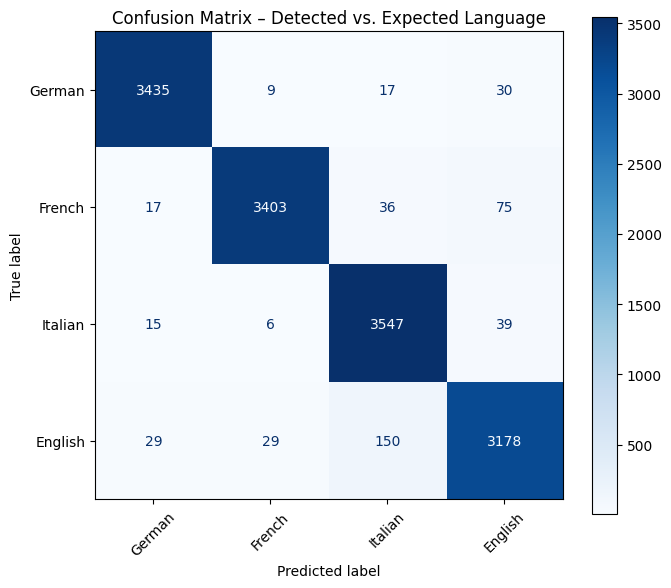

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Gather all detected and expected values
detected = []
expected = []

for col, lang in column_lang_mapping.items():
    detected += df[f'{col}_detected_lang'].tolist()
    expected += [lang] * len(df)

# Filter only those that are not empty
filtered = [(e, d) for e, d in zip(expected, detected) if d != 'not_found']
expected_filtered, detected_filtered = zip(*filtered)

# Confusion matrix
labels = ['german', 'french', 'italian', 'english']
cm = confusion_matrix(expected_filtered, detected_filtered, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[l.capitalize() for l in labels])

fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix – Detected vs. Expected Language")
plt.tight_layout()
plt.show()


In [12]:
# Step 1: Build a mapping of language to its _is_correct columns
from collections import defaultdict

lang_columns = defaultdict(list)
for col in df.columns:
    if col.endswith('_is_correct'):
        lang_key = col.split('_')[-3]  # DE, EN, etc.
        lang_columns[lang_key].append(col)

# Step 2: Evaluate reliability per language per dataset
for lang_key, cols in lang_columns.items():
    df[f'{lang_key}_reliable'] = df[cols].sum(axis=1) >= 2  # At least 2 correct

# Step 3: Count how many datasets are reliable per language
reliable_counts = {
    lang_key: df[f'{lang_key}_reliable'].sum()
    for lang_key in lang_columns.keys()
}
total_rows = len(df)

# Display results
for lang_key, count in reliable_counts.items():
    print(f"🟢 Language {lang_key}: {count} out of {total_rows} datasets considered reliable ({round(count / total_rows * 100, 2)}%)")


🟢 Language DE: 1206 out of 1224 datasets considered reliable (98.53%)
🟢 Language FR: 1204 out of 1224 datasets considered reliable (98.37%)
🟢 Language IT: 1213 out of 1224 datasets considered reliable (99.1%)
🟢 Language EN: 1189 out of 1224 datasets considered reliable (97.14%)


### Compare langid with langdetect

📥 Loading CSV file...
✅ CSV loaded successfully with 1224 rows
🔧 Generating column-language mapping...
✅ Column-language mapping created with 12 entries
🔍 Processing column: dataset_title_DE (expected: german)
🔍 Processing column: dataset_title_FR (expected: french)
🔍 Processing column: dataset_title_IT (expected: italian)
🔍 Processing column: dataset_title_EN (expected: english)
🔍 Processing column: dataset_description_DE (expected: german)
🔍 Processing column: dataset_description_FR (expected: french)
🔍 Processing column: dataset_description_IT (expected: italian)
🔍 Processing column: dataset_description_EN (expected: english)
🔍 Processing column: dataset_keyword_DE (expected: german)
🔍 Processing column: dataset_keyword_FR (expected: french)
🔍 Processing column: dataset_keyword_IT (expected: italian)
🔍 Processing column: dataset_keyword_EN (expected: english)
📊 Summarizing results for langdetect...
✅ Summary for langdetect complete with 12 entries
📊 Summarizing results for langid...

C:\Temp\QGIS\ipykernel_2476\3844962580.py:105: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=summary_all, x="Language", y="Percent Correct", hue="Method", ci=None)


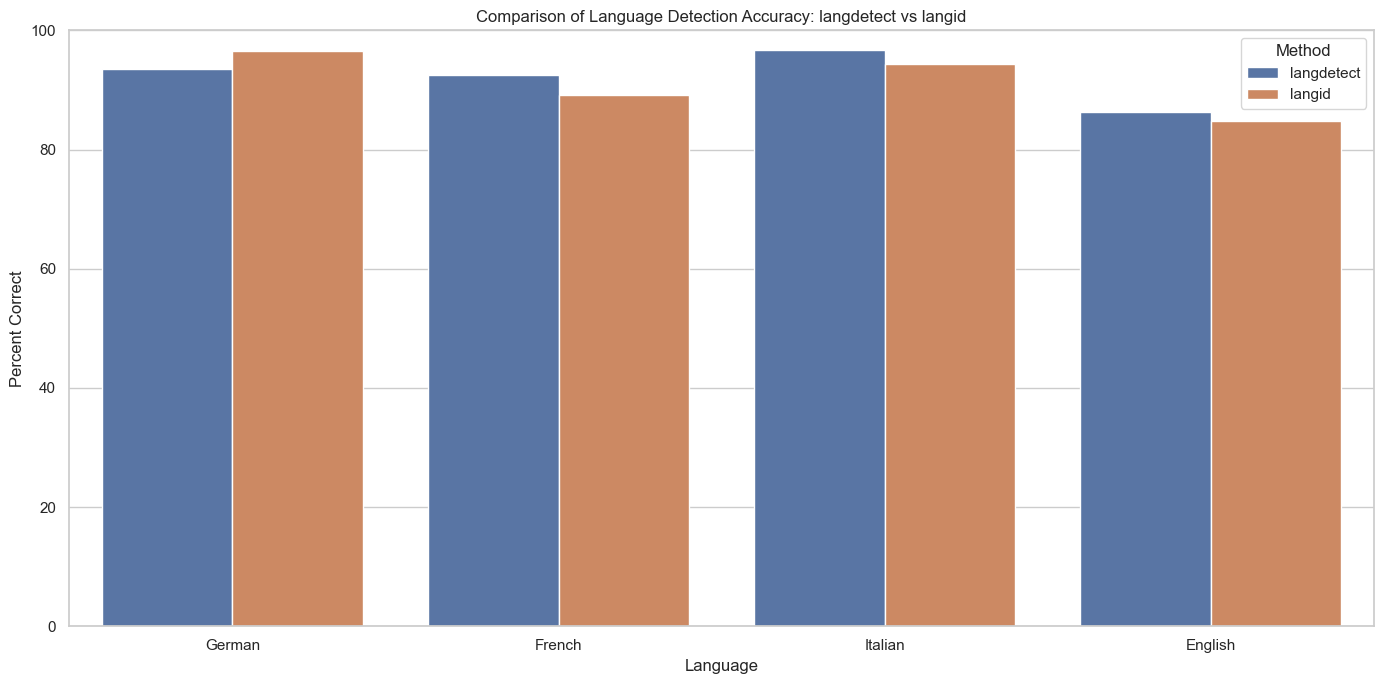

✅ Plot displayed


In [20]:
import pandas as pd
from langdetect import detect as detect_langdetect
from langid import classify as detect_langid
import re
import matplotlib.pyplot as plt

# Load UTF-8 CSV
print("📥 Loading CSV file...")
df = pd.read_csv(r"C:\Users\fabia\OneDrive - FHNW\03_FHNW\06_6_Semester\03_6000_BTh\91_NLP Unterlagen\language_detection\languages4_utf8.csv", encoding="utf-8")
print("✅ CSV loaded successfully with", len(df), "rows")

# Clean function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.replace('\xa0', ' ')
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)
    return text.strip()

# Language mappings
language_dict = {'en': 'english', 'fr': 'french', 'de': 'german', 'it': 'italian'}

# Detection functions
def detect_language_langdetect(phrase):
    try:
        return language_dict.get(detect_langdetect(phrase), 'not_found')
    except Exception as e:
        print(f"⚠️ langdetect failed for: {phrase[:30]}... | Error: {e}")
        return 'not_found'

def detect_language_langid(phrase):
    try:
        lang_code, _ = detect_langid(phrase)
        return language_dict.get(lang_code, 'not_found')
    except Exception as e:
        print(f"⚠️ langid failed for: {phrase[:30]}... | Error: {e}")
        return 'not_found'

# Define columns to check
base_columns = ['dataset_title', 'dataset_description', 'dataset_keyword']
languages = {'DE': 'german', 'FR': 'french', 'IT': 'italian', 'EN': 'english'}

# Generate full mapping
print("🔧 Generating column-language mapping...")
column_lang_mapping = {
    f"{base}_{lang}": expected_lang
    for base in base_columns
    for lang, expected_lang in languages.items()
    if f"{base}_{lang}" in df.columns
}
print("✅ Column-language mapping created with", len(column_lang_mapping), "entries")

# Clean, detect (both methods), and verify
for col, expected_lang in column_lang_mapping.items():
    print(f"🔍 Processing column: {col} (expected: {expected_lang})")
    df[f'{col}_clean'] = df[col].apply(clean_text)

    df[f'{col}_langdetect'] = df[f'{col}_clean'].apply(detect_language_langdetect)
    df[f'{col}_langid'] = df[f'{col}_clean'].apply(detect_language_langid)

    df[f'{col}_is_correct_langdetect'] = df[f'{col}_langdetect'] == expected_lang
    df[f'{col}_is_correct_langid'] = df[f'{col}_langid'] == expected_lang

# Compare results
def summarize_accuracy(method):
    summary = []
    for col, expected_lang in column_lang_mapping.items():
        correct_col = f'{col}_is_correct_{method}'
        if correct_col in df.columns:
            correct = df[correct_col].sum()
            total = df[correct_col].count()
            incorrect = total - correct
            percent_correct = round((correct / total) * 100, 2)
            percent_incorrect = round((incorrect / total) * 100, 2)

            summary.append({
                'Column': col,
                'Language': expected_lang.capitalize(),
                'Correct': correct,
                'Incorrect': incorrect,
                'Percent Correct': percent_correct,
                'Percent Incorrect': percent_incorrect,
                'Method': method
            })
    print(f"✅ Summary for {method} complete with {len(summary)} entries")
    return pd.DataFrame(summary)

print("📊 Summarizing results for langdetect...")
summary_langdetect = summarize_accuracy('langdetect')

print("📊 Summarizing results for langid...")
summary_langid = summarize_accuracy('langid')

summary_all = pd.concat([summary_langdetect, summary_langid], ignore_index=True)
print("✅ Combined summary created")

# Plot comparison
import seaborn as sns
sns.set(style="whitegrid")

print("📈 Plotting comparison chart...")
plt.figure(figsize=(14, 7))
sns.barplot(data=summary_all, x="Language", y="Percent Correct", hue="Method", ci=None)
plt.title("Comparison of Language Detection Accuracy: langdetect vs langid")
plt.ylabel("Percent Correct")
plt.xlabel("Language")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()
print("✅ Plot displayed")


📊 Plotting comparison chart per language and task...


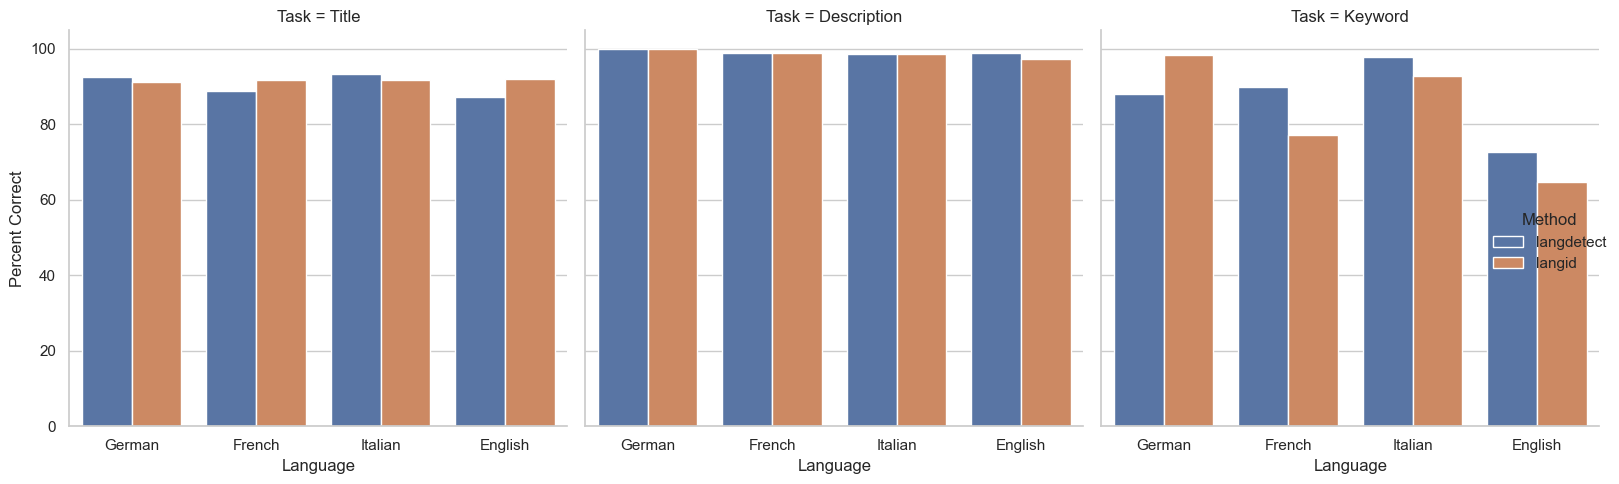

✅ Plot displayed


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add Task column for faceting
summary_all['Task'] = summary_all['Column'].apply(lambda x: x.split('_')[1].capitalize())

# Plot comparison per language and task
sns.set(style="whitegrid")
print("📊 Plotting comparison chart per language and task...")
sns.catplot(
    data=summary_all,
    x="Language",
    y="Percent Correct",
    hue="Method",
    col="Task",
    kind="bar",
    height=5,
    aspect=1
)
plt.tight_layout()
plt.show()
print("✅ Plot displayed")
